# <font color=#214B99>Projet 6 - Améliorez le produit IA de votre start-up</font>

# <font color=#009BFA>Partie B : Analyser les photos pour déterminer leurs catégories</font>

## Objectif du projet : 
- **Détecter les sujets d’insatisfaction présents dans les commentaires postés sur la plateforme**
- **Labelliser automatiquement les photos postées sur la plateforme.**
- **Collecter de nouvelles données via l’API Yelp**

## Trois parties :
- **Partie A : analyser les commentaires pour détecter les différents sujets d’insatisfaction**
- **Partie B : analyser les photos pour déterminer les catégories des photos**
- **Partie C : collecter un échantillon de données via l’API Yelp**

## <font color="#009BFA">Sommaire</font>
1. [Preprocessing des images](#section_1)<br>
    1.1. [Chargement de la description des photos](#section_1_1)<br>
    1.2. [Chargement des photos](#section_1_2)<br>
    1.3. [Pré-traitement des images](#section_1_3)<br>

2. [Cas d'un traitement standard des images](#section_2)<br>
    2.1. [Création des descripteurs pour chaque image : Extraction des features](#section_2_1)<br>
    2.2. [Création des clusters de descripteurs : Dictionnaire des Visual Words](#section_2_2)<br>
    2.3. [Création des Bag-of-features des images](#section_2_3)<br>
    2.4. [Utilisation des techniques de réduction de dimension](#section_2_4)<br>
    2.5. [Clustering avec le modèle K-means](#section_2_5)<br>
3. [Cas d'un traitement standard des images plus un filtre gaussien](#section_3)<br>
   
4. [Extraction des features en utilisation le modèle CNN + le Transfer Learning](#section_4)<br>
  
5. [Conclusion](#section_5)<br>

**Afin de rendre le travail effectué compréhensible et visualisable, nous avons :<br>
    - décrit de façon simple les différentes étapes et les algorithmes utilisés.<br>
    - ajouté de nombreux graphiques et utilisé des algorithmes et bibliothèques dédiés à la visualisation.**

***
## <font color=#B72000>Nota Bene</font>

- Des warnings apparaissent dans le Notebook, ces warnings sont causés par ceratines librairies.
- Ils apparaissent malgré le filtrage des warnings !
- Afin de les cacher merci de cliquer sur le bouton ci-dessous :

In [1]:
from IPython.display import HTML

HTML(
    """<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
POUR CACHER LES WARNINGS, CLIQUER <a href="javascript:code_toggle_err()">ICI</a>."""
)

In [313]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

<IPython.core.display.Javascript object>

In [314]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

<IPython.core.display.Javascript object>

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from os import listdir

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics

import json

import cv2

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model

# Valide code pep8
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [316]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

<IPython.core.display.Javascript object>

### Structuration du projet sous forme de fonctions :
- Les différentes étapes du projet sont écrites sous forme de fonction.
- Ces fonctions permettent d'automatiser l'analyse.
- Une fonction 'pipeline' regroupant ces fonctions est utilisée pour la version 2 de la modélisation utilisant l'algorithme SIFT.

 # <span style='color:blue' id="section_1" >1. Preprocessing des images</span>

> ## <span style='color:green' id="section_1_1" >1.1 Chargement de la description des photos</span>

In [317]:
path_descr_photos = "./yelp_photos/photos.json"

<IPython.core.display.Javascript object>

In [318]:
def load_descr_photos(path_descr_photos):
    df_description_photos = pd.read_json((path_descr_photos), lines=True)
    print("Chargement des descriptions des photos : OK")
    return df_description_photos

<IPython.core.display.Javascript object>

In [319]:
df_description_photos = load_descr_photos(path_descr_photos)

Chargement des descriptions des photos : OK


<IPython.core.display.Javascript object>

In [320]:
print(f"Nombre de descriptions photos : {df_description_photos.shape[0]}")

Nombre de descriptions photos : 200100


<IPython.core.display.Javascript object>

In [321]:
print("Nombre de descriptions photos par catégorie : ")
df_description_photos["label"].value_counts()

Nombre de descriptions photos par catégorie : 


food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Diagramme circulaire du nombre de descriptions photos par catégorie : 


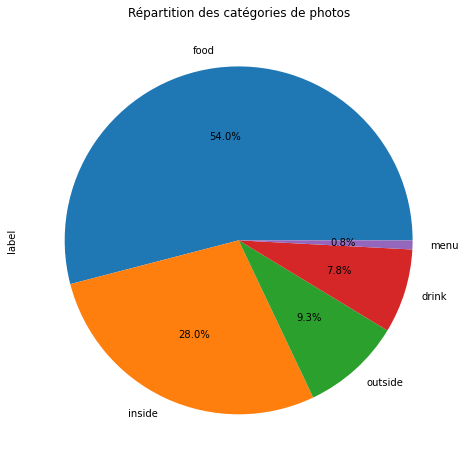

<IPython.core.display.Javascript object>

In [322]:
print("Diagramme circulaire du nombre de descriptions photos par catégorie : ")
_ = (
    df_description_photos["label"]
    .value_counts()
    .plot(
        kind="pie",
        figsize=(10, 8),
        autopct="%1.1f%%",
        title="Répartition des catégories de photos",
    )
)

#### Nous retenons un échantillon de 1 000 descriptions photos par catégorie, ce qui fait 5 000 descriptions photos au total

In [341]:
df_description_photos_sample = (
    df_description_photos.groupby("label")
    .apply(pd.DataFrame.sample, n=900, random_state=1)
    .reset_index(drop=True)
)


<IPython.core.display.Javascript object>

In [342]:
print(
    f"Nombre de descriptions photos de l'échantillon : {df_description_photos_sample.shape[0]}"
)

Nombre de descriptions photos de l'échantillon : 4500


<IPython.core.display.Javascript object>

In [343]:
print("Nombre de descriptions photos de l'échantillon par catégorie : ")
df_description_photos_sample["label"].value_counts()

Nombre de descriptions photos de l'échantillon par catégorie : 


drink      900
food       900
inside     900
menu       900
outside    900
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Diagramme circulaire du nombre de photos de l'échantillon par catégorie : 


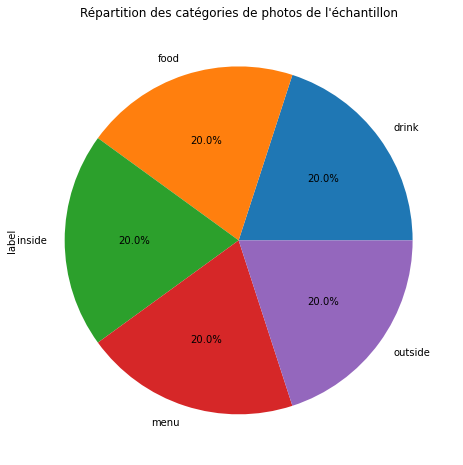

<IPython.core.display.Javascript object>

In [344]:
print("Diagramme circulaire du nombre de photos de l'échantillon par catégorie : ")
_ = (
    df_description_photos_sample["label"]
    .value_counts()
    .plot(
        kind="pie",
        figsize=(10, 8),
        autopct="%1.1f%%",
        title="Répartition des catégories de photos de l'échantillon",
    )
)

> ## <span style='color:green' id="section_1_2" >1.2. Chargement des photos</span>

In [345]:
path_photos = "./yelp_photos/photos/"

<IPython.core.display.Javascript object>

In [346]:
def load_photos(path_photos):
    list_photos = [file for file in listdir(path_photos)]
    print("Chargement des photos : OK")
    return list_photos

<IPython.core.display.Javascript object>

In [347]:
list_photos = load_photos(path_photos)

Chargement des photos : OK


<IPython.core.display.Javascript object>

#### Nous récupèrons les photos correspondantes aux descriptions photos de l'échantillon

In [348]:
list_photos_sample = [
    photo for photo in listdir(path_photos) and df_description_photos_sample["photo_id"]
]

<IPython.core.display.Javascript object>

#### Création de listes de photos par catégorie

In [349]:
list_photos_outside = [
    list_photos_sample[i]
    for i in range(len(list_photos_sample))
    if df_description_photos_sample["label"][i] == "outside"
]
list_photos_drink = [
    list_photos_sample[i]
    for i in range(len(list_photos_sample))
    if df_description_photos_sample["label"][i] == "drink"
]
list_photos_inside = [
    list_photos_sample[i]
    for i in range(len(list_photos_sample))
    if df_description_photos_sample["label"][i] == "inside"
]
list_photos_food = [
    list_photos_sample[i]
    for i in range(len(list_photos_sample))
    if df_description_photos_sample["label"][i] == "food"
]
list_photos_menu = [
    list_photos_sample[i]
    for i in range(len(list_photos_sample))
    if df_description_photos_sample["label"][i] == "menu"
]

<IPython.core.display.Javascript object>

In [350]:
print(f"Nombre de photos dans notre échantillon : {len(list_photos_sample)}")
print(f"Nombre de photos par catégorie : {len(list_photos_drink)}")

Nombre de photos dans notre échantillon : 4500
Nombre de photos par catégorie : 900


<IPython.core.display.Javascript object>

### <font style='color:#015995'>Exemples de photos par catégorie :</font>

In [351]:
list_labels = ["outside", "drink", "inside", "food", "menu"]

<IPython.core.display.Javascript object>

In [352]:
def list_fct(name):
    list_photos_name = [
        list_photos_sample[i]
        for i in range(len(list_photos_sample))
        if df_description_photos_sample["label"][i] == name
    ]
    return list_photos_name

<IPython.core.display.Javascript object>

In [353]:
def print_photos_sample(path_photos):

    for label in list_labels:
        f = plt.figure(figsize=(12, 10))
        print("Exemple de photos pour la catégorie : ", label)
        for i in range(4):
            f.add_subplot(140 + 1 + i)
            filename = path_photos + list_fct(label)[i] + ".jpg"
            photo = cv2.imread(filename)
            plt.imshow(photo)
        plt.show()

<IPython.core.display.Javascript object>

Exemple de photos pour la catégorie :  outside


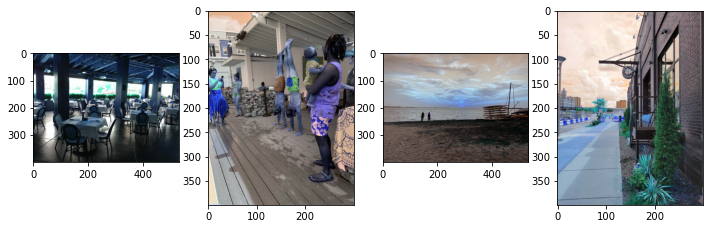

Exemple de photos pour la catégorie :  drink


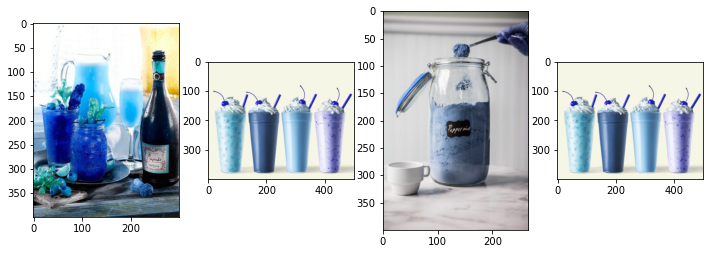

Exemple de photos pour la catégorie :  inside


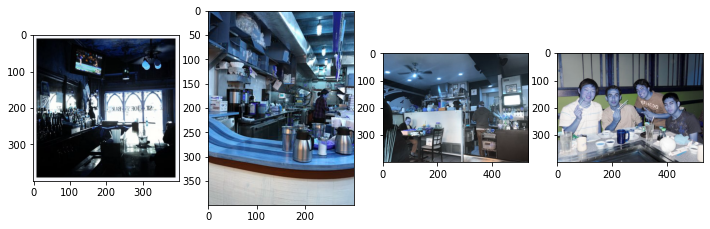

Exemple de photos pour la catégorie :  food


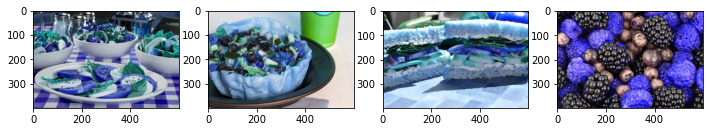

Exemple de photos pour la catégorie :  menu


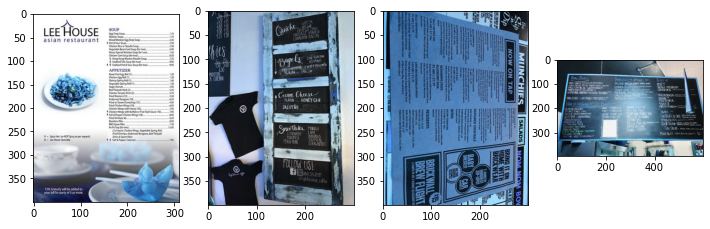

<IPython.core.display.Javascript object>

In [354]:
print_photos_sample(path_photos)

> ## <span style='color:green' id="section_1_3" >1.3. Pré-traitement des images</span>

En vision par ordinateur, le terme de (local) features désigne des zones intéressantes de l'image numérique. Ces zones peuvent correspondre à des contours, des points ou des régions d'intérêt. A chaque feature détectée est associé un vecteur, appelé descripteur (feature descriptor ou feature vector), qui, comme son nom l'indique, décrit la zone concernée.<br>
La détection et la description de features constituent la première étape indispensable pour de nombreuses autres tâches en vision par ordinateur, comme la classification d'images. [Source](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5044811-decouvrez-la-notion-de-features-dans-une-image)

> ## <span style='color:#D55802' id="section_1_3">Pré-traitement des images en utilisant l'algorithme SIFT</span>
- Cet algorithme (Scale-Invariant Feature Transform) de référence va nous permettre, grâce à des traitements mathématiques complexes, de :
    - Eextraire des features (ou points d'intérêt) de l'image, les `Keypoints`.
    - Décrire ces points d'intérêt, les `Descripteurs`.<br>

N.B. Chaque feature est une zone circulaire intéressante, repérée par son centre (point d'intérêt), et dont le rayon est proportionnel à son échelle caractéristique. La force du détecteur SIFT est sa capacité à trouver des rayons différents, et donc des features de différentes tailles.

### <font style='color:#006077'>Exemple de détermination et affichage des descripteurs SIFT pour une image</font>

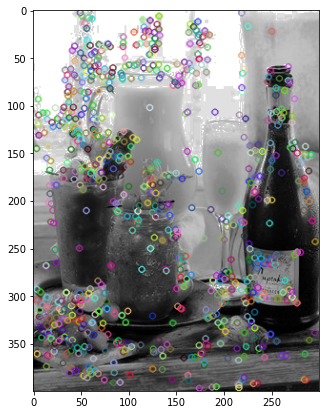

Descripteurs :  (834, 128)

[[  5.  15.  59. ...   0.   0.   0.]
 [ 10. 130.  66. ...   0.   0.   0.]
 [  7.   0.   0. ...  11.   1.   0.]
 ...
 [  2.   0.   0. ...   0.   0.   0.]
 [ 30. 104.   8. ...   0.   0.   5.]
 [  4.   2.   5. ...   0.   0.   1.]]


<IPython.core.display.Javascript object>

In [355]:
sift = cv2.SIFT_create()

photo = cv2.imread(
    path_photos + df_description_photos_sample["photo_id"][0] + ".jpg", 0
)  # convert in gray  (0 = cv2.IMREAD_GRAYSCALE)

photo = cv2.equalizeHist(photo)  # equalize image histogram
# photo = cv2.resize(photo, (224, 224))
keypoints, descriptors = sift.detectAndCompute(photo, None)
photo = cv2.drawKeypoints(photo, keypoints, photo)

plt.figure(figsize=(15, 7))
plt.imshow(photo)
plt.show()
print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)

In [356]:
len(descriptors)

834

<IPython.core.display.Javascript object>

 # <span style='color:blue' id="section_2" >2. Cas d'un traitement standard des images</span>
- Dans ce cas de figure le traitement effectué sur les images est :
    - **Conversion en nuances de gris**
    - **Egalisation de l'histogramme**

> ## <span style='color:green' id="section_2_1" >2.1. Création des descripteurs pour chaque image : Extraction des features</span>
- Création d'une liste de descripteurs par image qui sera utilisée pour réaliser les histogrammes / image.
- Un descripteur est un vecteur qui décrit le voisinage de la feature à laquelle il est associé.
- Création d'une liste de descripteurs pour l'ensemble des images qui sera utilisée pour créer les clusters de descripteurs.

In [357]:
def build_descriptors(list_photos_sample, path_photos):
    sift_descriptors = []
    sift = cv2.SIFT_create(500)

    for photo_num in range(len(list_photos_sample)):
        photo_path = path_photos + list_photos_sample[photo_num] + ".jpg"
        photo = cv2.imread(photo_path, 1)
        # photo = cv2.resize(photo, (224, 224))
        photo = cv2.cvtColor(photo, cv2.COLOR_RGB2GRAY)  # convert in gray

        # photo = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)  # convert in gray
        photo = cv2.equalizeHist(photo)  # equalize image histogram
        # photo = cv2.resize(photo, (224, 224))

        keypoints, descriptors = sift.detectAndCompute(photo, None)
        sift_descriptors.append(descriptors)

    sift_descriptors_by_photo = np.asarray(sift_descriptors, dtype=object)
    sift_descriptors_all = np.concatenate(sift_descriptors_by_photo, axis=0)

    print("Création des descripteurs : OK")

    return sift_descriptors_by_photo, sift_descriptors_all

<IPython.core.display.Javascript object>

In [358]:
sift_descriptors_by_photo, sift_descriptors_all = build_descriptors(
    list_photos_sample, path_photos
)

libpng warning: iCCP: known incorrect sRGB profile


Création des descripteurs : OK


<IPython.core.display.Javascript object>

In [359]:
print("Nombre de descripteurs : ", sift_descriptors_all.shape[0])
print("Taille des descripteurs : ", sift_descriptors_all.shape[1])

Nombre de descripteurs :  2196237
Taille des descripteurs :  128


<IPython.core.display.Javascript object>

> ## <span style='color:green' id="section_2_2" >2.2. Création des clusters de descripteurs : Dictionnaire des Visual Words</span>

- Création des Visual Words : les features qui se déclinent en plusieurs versions sont appelées des Visual Words (par analogie au traitement du texte).
    - On regroupe les features similaires dans des Visual Words.
    - Pour créer le dictionnaire des Visual Words, on utilise un algorithme de clustering.
    - En sortie du clustering, les centroïdes correspondent au regroupement des features similaires en visual words : Centroides = Visual Words.
    - On obtient un disctionnaire de Visual Words.
- Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables.

In [360]:
def clustering_descriptors(sift_descriptors_all):
    # Determination number of clusters
    k = int(round(np.sqrt(len(sift_descriptors_all)), 0))
    print("Nombre de clusters de descripteurs estimés : ", k)
    print("Création de", k, "Visual Words")

    # Clustering
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=3 * k, random_state=42)
    kmeans.fit(sift_descriptors_all)

    print("Clustering : OK")

    return kmeans

<IPython.core.display.Javascript object>

In [361]:
kmeans = clustering_descriptors(sift_descriptors_all)

Nombre de clusters de descripteurs estimés :  1482
Création de 1482 Visual Words
Clustering : OK


<IPython.core.display.Javascript object>

In [362]:
print("Dictionnaire des Visual Words :")
dico_visual_words = kmeans.cluster_centers_  # ce sont les visuals words
dico_visual_words

Dictionnaire des Visual Words :


array([[17.785147 , 15.594541 , 13.59725  , ...,  5.342539 ,  3.964341 ,
         9.898406 ],
       [25.11236  , 20.362234 , 18.007675 , ..., 36.773037 , 16.055782 ,
        11.357428 ],
       [22.380913 , 42.09592  , 44.732784 , ...,  8.105823 ,  5.4127855,
        11.874651 ],
       ...,
       [14.68996  , 11.597877 , 13.502745 , ...,  8.199079 ,  7.3667803,
         8.713105 ],
       [30.52909  , 81.56609  , 59.480835 , ..., 25.39634  , 13.102134 ,
         9.564413 ],
       [ 7.321357 ,  7.882165 , 11.511104 , ...,  5.9218626,  4.19516  ,
        10.07816  ]], dtype=float32)

<IPython.core.display.Javascript object>

In [363]:
print("Nombre de Visual Words : ", dico_visual_words.shape[0])
print("Taille de Visual Words : ", dico_visual_words.shape[1])

Nombre de Visual Words :  1482
Taille de Visual Words :  128


<IPython.core.display.Javascript object>

Maintenant que nous avons détecté et décrit les features d'une image, nous allons en servir pour classifier des images.

La classification d'images est un problème fondamental en vision par ordinateur, qui a de nombreuses applications concrètes. Le but est de construire un système capable d'assigner correctement une catégorie à n'importe quelle image en entrée. Un tel système exploite des algorithmes de Machine Learning issus de l'apprentissage supervisé.  

Le schéma ci-dessous illustre la méthode utilisée pour résoudre un problème de classification d'images.
![Le schéma de la méthode utilisée pour la classification:](methode_classif.png)

> ## <span style='color:green' id="section_2_3" >2.3. Création des Bag-of-features des images</span>
Le bag-of-features d'une image est le vecteur dans lequel on a stocké les valeurs de l'histogramme, qui indique la fréquence d'apparition de chaque visual word dans l'image, et qu'on a normalisé (en divisant par la norme euclidienne). [Source](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5072281-utilisez-ces-features-pour-classifier-des-images)
- Construction des histogrammes : 
    - Il reste à décrire les images en fonction de ces Visual Words.
    - Pour chaque image :
       - prédiction des numéros de cluster de chaque descripteur.
       - création d'un histogramme qui indique la fréquence d'apparition de chaque Visual Word dans l'image = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image.

> On obtient le Bag Of Visual Features d'une image qui est le vecteur dans lequel on a stocké les valeurs de l'histogramme et que l'on a normalisé.

In [365]:
def build_histogram_picture(kmeans, photo_descriptors, photo_num):
    # We get the visual words corresponding to each descriptor of the photo
    photo_descriptors_predict = kmeans.predict(photo_descriptors)
    length_descriptors = photo_descriptors.shape[0]

    # Length of histogram = size of the cluster centers
    photo_histogram = np.zeros(len(kmeans.cluster_centers_))

    if length_descriptors == 0:
        print("problème histogramme image  : ", photo_num)
    for i in photo_descriptors_predict:
        photo_histogram[i] += 1.0 / length_descriptors

    return photo_histogram

<IPython.core.display.Javascript object>

In [366]:
def build_bag_features(kmeans, sift_descriptors_by_photo):
    # Creation of a matrix of histograms
    histogram_vectors = []

    for i, photo_descriptors in enumerate(sift_descriptors_by_photo):
        photo_histogram = build_histogram_picture(kmeans, photo_descriptors, i)
        # calculates the histogram
        histogram_vectors.append(photo_histogram)  # histogram is the feature vector

    # Bag of visual features
    photo_features = np.asarray(histogram_vectors, dtype=object)

    print("Création des bag-of-features : OK")

    return photo_features

<IPython.core.display.Javascript object>

In [367]:
photo_features = build_bag_features(kmeans, sift_descriptors_by_photo)

Création des bag-of-features : OK


<IPython.core.display.Javascript object>

In [368]:
print("Taille de la matrice des bag-of-features :")
photo_features.shape

Taille de la matrice des bag-of-features :


(4500, 1482)

<IPython.core.display.Javascript object>

> ## <span style='color:green' id="section_2_4" >2.4. Utilisation des techniques de réduction de dimension</span>

### Réduction de dimension PCA
- La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé.
- Cela permettra une meilleure séparation des données lors de l'utilisation de l'algorithme T-SNE ainsi qu'une réduction du temps de traitement.
> Cette technique nous permettra de réduire la dimension sans trop perdre de l'information. 

In [369]:
print("Dimensions du dataset avant réduction PCA : ", photo_features.shape)

Dimensions du dataset avant réduction PCA :  (4500, 1482)


<IPython.core.display.Javascript object>

In [407]:
def pca_reduction(photo_features):
    # We keep 99% of the variance
    pca = PCA(n_components=0.99)
    photo_features_pca = pca.fit_transform(photo_features)

    print("Réduction de dimension PCA : OK")

    return photo_features_pca

<IPython.core.display.Javascript object>

In [408]:
pca_photo_features = pca_reduction(photo_features)

Réduction de dimension PCA : OK


<IPython.core.display.Javascript object>

In [409]:
print("Dimensions dataset après réduction PCA : ", pca_photo_features.shape)

Dimensions dataset après réduction PCA :  (4500, 1351)


<IPython.core.display.Javascript object>

> ## <font style='color:#D55802'> Visualisation des données de grandes dimensions</font>

> ## <font style='color:#036BB2'> Réduction de dimension et visualisation t-SNE</font>

- La méthode t-SNE (T-distributed Stochastic Neighbor Embedding) effectue une réduction de dimension tout en essayant de conserver les observations semblables proches et les observations dissemblables éloignées. Cette méthode est utilisée surtout pour la visualisation, et en particulier pour visualiser des groupes d'observations dans un espace de grande dimension.
- Chaque image est résumée par 2 coordonnées t-SNE qui ont été produites par réduction de dimension des bag-of-features.<br>
<br>
- Le principe de la t-SNE est le suivant :
    - Il effectue une réduction de dimension tout en essayant de conserver les observations semblables proches et les observations dissemblables éloignées.
    - On calcule pour chaque observation une probabilité conditionnelle en fonction de la distance aux autres observations. Ces probabilités représentent les similarités entre points de données dans l'espace initial.
    - A partir de ces probabilités Pi dans l'espace de grande dimension, l'algorithme va produire une nouvelle distribution Qi (qui est une t-distribution de Student) dans l'espace de plus petite dimension en minimisant une fonction de coût.
    - La nouvelle distribution Qi est une T-distribution de Student et la fonction de coût la divergence de Kullback-Leibler entre la probabilité d'origine et la probabilité d'arrivée.
    - Avec la nouvelle distribution on peut reconstruire l'ensemble de points dans l'epace de redéfinition de plus petite dimension.
    - L'optimisation de la fonction de coût se fait grâce à une descente de gradient.

In [410]:
def tsne_reduction(pca_photo_features, df_description_photos_sample):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=42)
    photo_features_tsne = tsne.fit_transform(pca_photo_features)

    df_photo_features_tsne = pd.DataFrame(
        photo_features_tsne[:, 0:2], columns=["tsne1", "tsne2"]
    )
    df_photo_features_tsne["label"] = df_description_photos_sample["label"]

    print("Réduction de dimension TSNE : OK")

    return df_photo_features_tsne

<IPython.core.display.Javascript object>

In [411]:
df_photo_features_tsne = tsne_reduction(
    pca_photo_features, df_description_photos_sample
)

/home/kader/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kader/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension TSNE : OK


<IPython.core.display.Javascript object>

In [412]:
print("Dimension du dataframe tsne :")
print(df_photo_features_tsne.shape)

Dimension du dataframe tsne :
(4500, 3)


<IPython.core.display.Javascript object>

In [413]:
print("Dataframe tsne :")
df_photo_features_tsne

Dataframe tsne :


,tsne1,tsne2,label
0,3.391799,48.812794,drink
1,19.544662,64.074242,drink
2,23.660574,31.201067,drink
3,21.152376,62.713760,drink
4,2.039680,7.585389,drink
...,...,...,...
4495,-12.960133,-33.555286,outside
4496,18.648087,12.829640,outside
4497,19.357761,2.774028,outside
4498,11.823707,20.386440,outside


<IPython.core.display.Javascript object>

> ## <font style='color:#036BB2'> Affichage t-SNE selon la catégorie des images :</font>
- On va regarder si ces images dans l'espace TSNE sont groupées selon la même catégorie et séparées selon les différentes catégories
> Si c'est le cas, cela signifie que l'on a réussi à séparer les images selon leur catégorie (une classification n non-supervisée)

In [414]:
def tsne_visualization(df_photo_features_tsne):
    plt.figure(figsize=(14, 10))

    sns.scatterplot(
        x="tsne1",
        y="tsne2",
        hue="label",
        data=df_photo_features_tsne,
        legend="brief",
        palette=sns.color_palette("bright", n_colors=5),
        s=30,
        alpha=0.5,
    )

    plt.title(
        "Visualisation en dimension réduite, t-SNE, selon les catégories d'origines",
        fontsize=20,
        pad=35,
    )
    plt.xlabel("Dimension réduite tsne_1", fontsize=22)
    plt.ylabel("Dimension réduite tsne_2", fontsize=22)
    plt.legend(prop={"size": 14})

    plt.show()

<IPython.core.display.Javascript object>

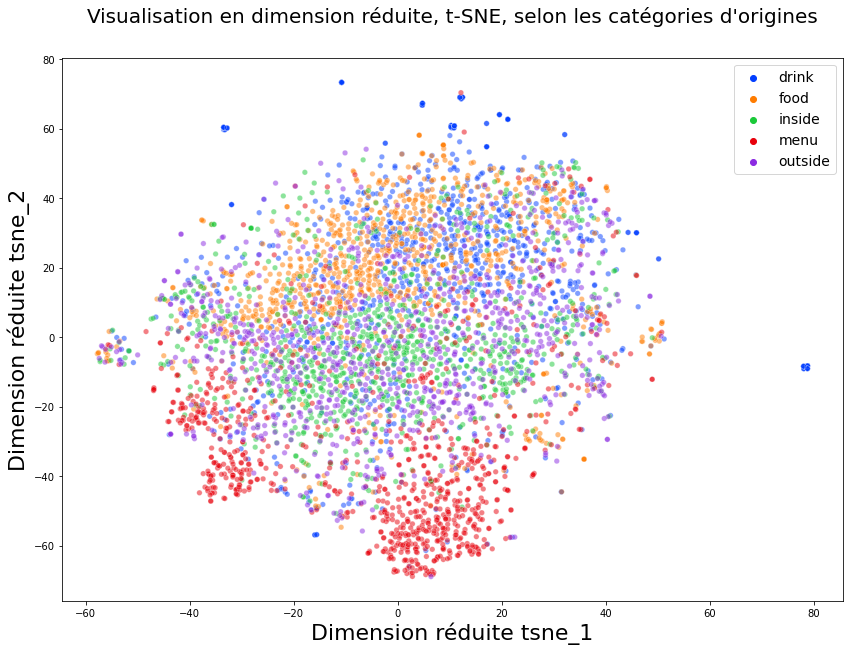

<IPython.core.display.Javascript object>

In [415]:
tsne_visualization(df_photo_features_tsne)

> ###  <font color=#0088B4>Synthèse</font>
- Les résultats ne sont pas du tout satisfaisants.
- Seule la catégorie 'menu' est à peu près bien séparée.

> ## <span style='color:green' id="section_2_5" >2.5. Clustering avec le modèle K-means</span>

> ## <font style='color:#036BB2'>Création de clusters à partir de la modélisation t-SNE :</font>

In [416]:
def tsne_clustering(df_photo_features_tsne):
    clusters = KMeans(n_clusters=5, random_state=42)
    clusters.fit(df_photo_features_tsne[["tsne1", "tsne2"]].to_numpy())

    df_photo_features_tsne["cluster"] = clusters.labels_

    print("Clustering TSNE : OK")

    return df_photo_features_tsne

<IPython.core.display.Javascript object>

In [417]:
df_photo_features_tsne_clusters = tsne_clustering(df_photo_features_tsne)

Clustering TSNE : OK


<IPython.core.display.Javascript object>

In [418]:
print("Dimension du dataframe tsne :")
print(df_photo_features_tsne_clusters.shape)

Dimension du dataframe tsne :
(4500, 4)


<IPython.core.display.Javascript object>

In [419]:
print("Dataframe tsne :")
df_photo_features_tsne_clusters

Dataframe tsne :


,tsne1,tsne2,label,cluster
0,3.391799,48.812794,drink,2
1,19.544662,64.074242,drink,2
2,23.660574,31.201067,drink,2
3,21.152376,62.713760,drink,2
4,2.039680,7.585389,drink,4
...,...,...,...,...
4495,-12.960133,-33.555286,outside,1
4496,18.648087,12.829640,outside,0
4497,19.357761,2.774028,outside,0
4498,11.823707,20.386440,outside,2


<IPython.core.display.Javascript object>

> ## <font style='color:#036BB2'>Affichage des images selon les clusters K-means :</font>

In [420]:
def tsne_clusters_vizualization(df_photo_features_tsne_clusters):
    plt.figure(figsize=(14, 10))

    sns.scatterplot(
        x="tsne1",
        y="tsne2",
        hue="cluster",
        palette=sns.color_palette("bright", n_colors=5),
        s=30,
        alpha=0.5,
        data=df_photo_features_tsne_clusters,
        legend="brief",
    )

    plt.title(
        "Visualisation en dimension réduite, t-SNE, selon les clusters K-means",
        fontsize=20,
        pad=35,
    )
    plt.xlabel("Dimension réduite tsne_1", fontsize=22)
    plt.ylabel("Dimension réduite tsne_2", fontsize=22)
    plt.legend(prop={"size": 14})

    plt.show()

<IPython.core.display.Javascript object>

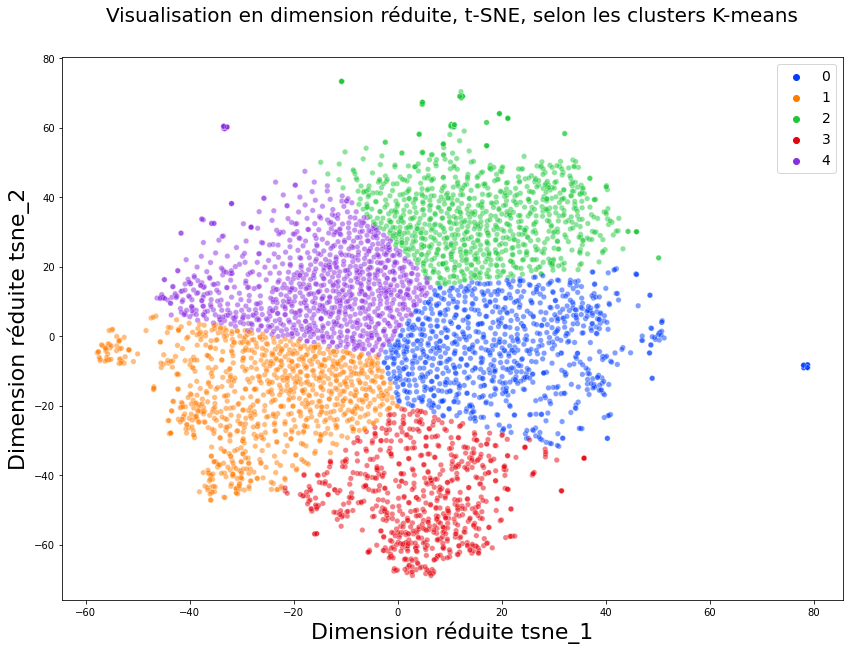

<IPython.core.display.Javascript object>

In [421]:
tsne_clusters_vizualization(df_photo_features_tsne_clusters)

### <font style='color:#036BB2'>Calcul du score ARI :</font> 
> ### <font style='color:#036BB2'> le score de similarité entre les catégories des images et les labels obtenus par le K-means</font>

In [422]:
def compute_ari_score(labels, clusters):
    ari_score = metrics.adjusted_rand_score(labels, clusters)
    return ari_score

<IPython.core.display.Javascript object>

In [423]:
labels = df_photo_features_tsne_clusters["label"]
clusters = df_photo_features_tsne_clusters["cluster"]
score_ari = compute_ari_score(labels, clusters)
print("Score ARI = %.3f" % (score_ari))

Score ARI = 0.125


<IPython.core.display.Javascript object>

> ###  <font color=#0088B4>Synthèse</font>
- Le score ARI de 0.12 est faible
- Seul le cluster 1 est identifiable, il correspond à la catégorie 'menu'

# <span style='color:blue' id="section_3" >3. Cas d'un traitement standard des images plus un filtre gaussien</span>
- Le traitement effectué sur les images est :
    - **Conversion en nuances de gris.**
    - **Egalisation de l'histogramme.**
    - **Application d'un filtre gaussien pour filtrer le bruit.**

In [424]:
def build_descriptors_v2(list_photos_sample, path_photos):
    sift_descriptors = []
    sift = cv2.SIFT_create(500)

    for photo_num in range(len(list_photos_sample)):
        photo_path = path_photos + list_photos_sample[photo_num] + ".jpg"

        photo = cv2.imread(photo_path, 1)
        # photo = cv2.resize(photo, (224, 224))
        photo = cv2.cvtColor(photo, cv2.COLOR_RGB2GRAY)
        photo = cv2.equalizeHist(photo)
        # photo = cv2.medianBlur(photo,5)
        photo = cv2.GaussianBlur(photo, (5, 5), 0)

        keypoints, descriptors = sift.detectAndCompute(photo, None)
        sift_descriptors.append(descriptors)

    sift_descriptors_by_photo = np.asarray(sift_descriptors, dtype=object)
    sift_descriptors_all = np.concatenate(sift_descriptors_by_photo, axis=0)

    print("Création des descripteurs : OK")

    return sift_descriptors_by_photo, sift_descriptors_all

<IPython.core.display.Javascript object>

#### Remarque :
- Nous créons une fonction 'pipeline' regroupant les fonctions de  preprocessing, modélisation et visualisation
- Cela permet d'automatiser le processus

In [425]:
def pipeline_photos_analysis(
    list_photos_sample, path_photos, df_description_photos_sample
):
    # Création des descripteurs
    (
        sift_descriptors_by_photo,
        sift_descriptors_all,
    ) = build_descriptors_v2(list_photos_sample, path_photos)

    # Clustering : création des Visual Words
    kmeans = clustering_descriptors(sift_descriptors_all)

    # Création des Bags Of Visual Words
    photo_features = build_bag_features(kmeans, sift_descriptors_by_photo)

    # Réduction de dimension PCA
    print("Dimensions dataset avant réduction PCA : ", photo_features.shape)
    photo_features_pca = pca_reduction(photo_features)
    print("Dimensions dataset après réduction PCA : ", photo_features_pca.shape)

    # Réduction de dimension TSNE
    df_photo_features_tsne = tsne_reduction(
        photo_features_pca, df_description_photos_sample
    )

    # Visualisation TSNE
    tsne_visualization(df_photo_features_tsne)

    # Clustering TSNE
    df_photo_features_tsne_clusters = tsne_clustering(df_photo_features_tsne)

    # Visualisation Clusters TSNE
    tsne_clusters_vizualization(df_photo_features_tsne_clusters)

    # Compute ARI Score
    labels = df_photo_features_tsne_clusters["label"]
    clusters = df_photo_features_tsne_clusters["cluster"]
    score_ari = compute_ari_score(labels, clusters)
    print("Score ARI = %.3f" % (score_ari))

<IPython.core.display.Javascript object>

libpng warning: iCCP: known incorrect sRGB profile


Création des descripteurs : OK
Nombre de clusters de descripteurs estimés :  1464
Création de 1464 Visual Words
Clustering : OK
Création des bag-of-features : OK
Dimensions dataset avant réduction PCA :  (4500, 1464)
Réduction de dimension PCA : OK
Dimensions dataset après réduction PCA :  (4500, 1347)


/home/kader/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kader/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension TSNE : OK


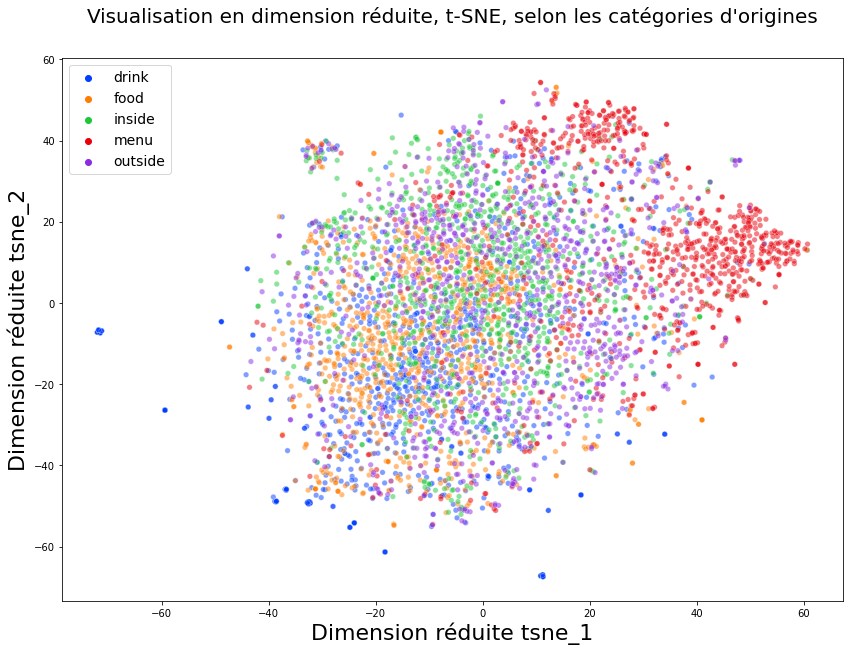

Clustering TSNE : OK


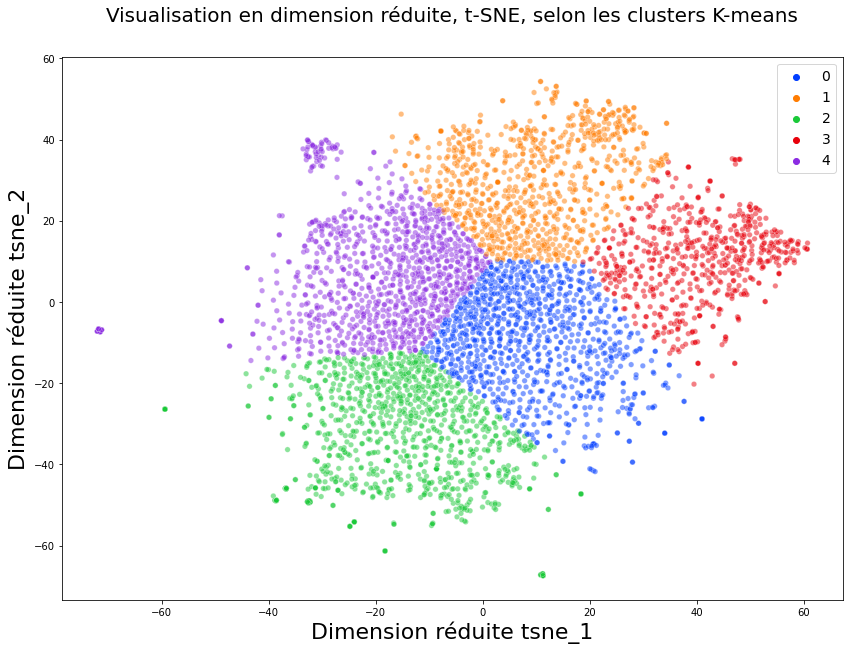

Score ARI = 0.100


<IPython.core.display.Javascript object>

In [426]:
pipeline_photos_analysis(list_photos_sample, path_photos, df_description_photos_sample)

> ###  <font color=#0088B4>Synthèse</font>
- Le score ARI de 0.10 est très faible et inférieur à la version précédente
- Seul le cluster 3 est identifiable, il correspond à la catégorie 'menu'

# <span style='color:blue' id="section_4" >4. Extraction des features en utilisation le modèle CNN + Transfer Learning</span>

Les réseaux de neurones convolutifs (Convolutional Neural Network, CNN) désignent une sous-catégorie de réseaux de neurones : les CNN sont spécialement conçus pour traiter des images en entrée.<br>
Les réseaux de neurones convolutifs ont une méthodologie similaire à celle des méthodes traditionnelles d'apprentissage supervisé : ils reçoivent des images en entrée, détectent les features de chacune d'entre elles, puis entraînent un classifieur dessus.<br>
`Les CNN réalisent eux-mêmes tout le boulot fastidieux d'extraction et description de features : lors de la phase d'entraînement, l'erreur de classification est minimisée afin d'optimiser les paramètres du classifieur ET les features` ! 

Concrétement, chaque image reçue en entrée va donc être filtrée, réduite et corrigée plusieurs fois, pour finalement former un vecteur. Dans le problème de classification, ce vecteur contient les probabilités d'appartenance aux classes.

- On utilise un modèle pré-entrainé sur un grand nombre d'autres images.
- On va utiliser les features qui sont extraites par ce modèle  pour notre probléme.
- Nous allons utiliser pour cela le modèle VGG16.

> ## <font style='color:#036BB2'>Mise en place du modèle pré-entrainé</font> 

In [427]:
def get_vgg16_model(layer="fc2"):
    """Keras Model of the VGG16 network, with the output layer set to `layer`.
    The default layer is the second-to-last fully connected layer 'fc2' of
    shape (4096,).
    Parameters
    ----------
    layer : str
        which layer to extract (must be of shape (None, X)), e.g. 'fc2', 'fc1'
        or 'flatten'
    """

    base_model = VGG16(weights="imagenet", include_top=True)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
    return model

<IPython.core.display.Javascript object>

In [428]:
vgg16_model = get_vgg16_model()

<IPython.core.display.Javascript object>

In [429]:
print("Architecture du réseau VGG16 : \n")
vgg16_model.summary()

Architecture du réseau VGG16 : 

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)

<IPython.core.display.Javascript object>

> ## <font style='color:#036BB2'>Extraction des features avec le modèle pré-entrainé</font> 

In [430]:
def build_features_transfer_learning(list_photos_sample, path_photos, model):
    features_transfer_learning = []

    for photo_num in range(len(list_photos_sample)):
        photo_path = path_photos + list_photos_sample[photo_num] + ".jpg"

        photo = cv2.imread(photo_path)
        photo = cv2.resize(photo, (224, 224))

        photo = np.expand_dims(photo, axis=0)
        photo = preprocess_input(photo)

        features_predict = model.predict(photo)
        features_predict_flatten = features_predict.flatten()

        features_transfer_learning.append(features_predict_flatten)

    photos_features_transfer_learning = np.asarray(
        features_transfer_learning, dtype=object
    )

    print("Création des features de photos par transfer learning : OK")

    return photos_features_transfer_learning

<IPython.core.display.Javascript object>

### Fonction 'pipeline' pour :
- Extraction des features
- Réduction de dimension
- Visualisation
- Evaluation

In [431]:
def pipeline_photos_analysis_transfer_learning(
    list_photos_sample, path_photos, df_description_photos_sample, model
):
    # Création des features par transfer learning
    photos_features_transfer_learning = build_features_transfer_learning(
        list_photos_sample, path_photos, model
    )

    # Réduction de dimension PCA
    print(
        "Dimensions dataset avant réduction PCA : ",
        photos_features_transfer_learning.shape,
    )
    photo_features_pca = pca_reduction(photos_features_transfer_learning)
    print("Dimensions dataset après réduction PCA : ", photo_features_pca.shape)

    # Réduction de dimension TSNE
    df_photo_features_tsne = tsne_reduction(
        photo_features_pca, df_description_photos_sample
    )

    # Visualisation TSNE
    tsne_visualization(df_photo_features_tsne)

    # Clustering TSNE
    df_photo_features_tsne_clusters = tsne_clustering(df_photo_features_tsne)

    # Visualisation Clusters TSNA
    tsne_clusters_vizualization(df_photo_features_tsne_clusters)

    # Compute ARI Score
    labels = df_photo_features_tsne_clusters["label"]
    clusters = df_photo_features_tsne_clusters["cluster"]
    score_ari = compute_ari_score(labels, clusters)
    print("Score ARI - Transfer Learning = %.3f" % (score_ari))

    return photos_features_transfer_learning, df_photo_features_tsne_clusters

<IPython.core.display.Javascript object>

libpng warning: iCCP: known incorrect sRGB profile


Création des features de photos par transfer learning : OK
Dimensions dataset avant réduction PCA :  (4500, 4096)
Réduction de dimension PCA : OK
Dimensions dataset après réduction PCA :  (4500, 2347)


/home/kader/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kader/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension TSNE : OK


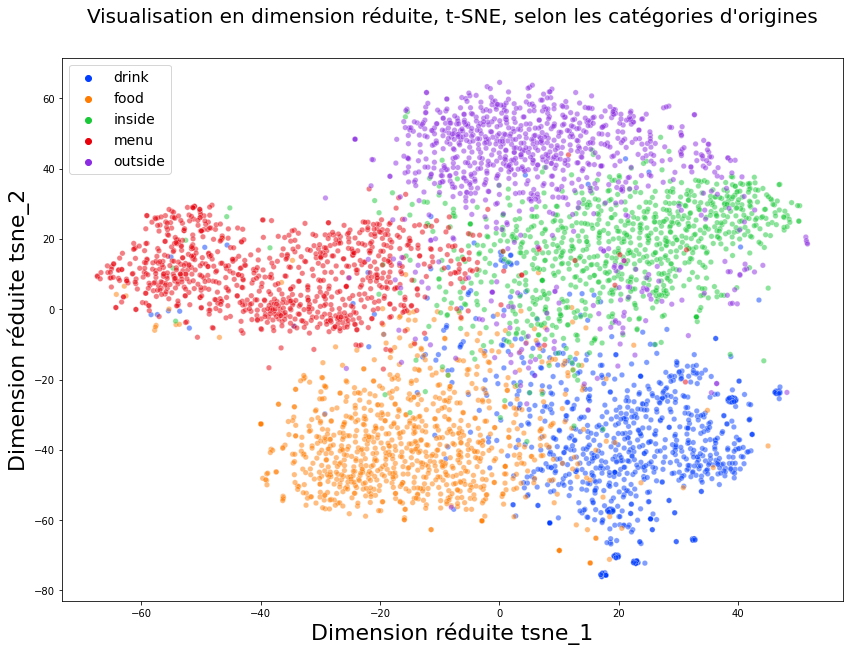

Clustering TSNE : OK


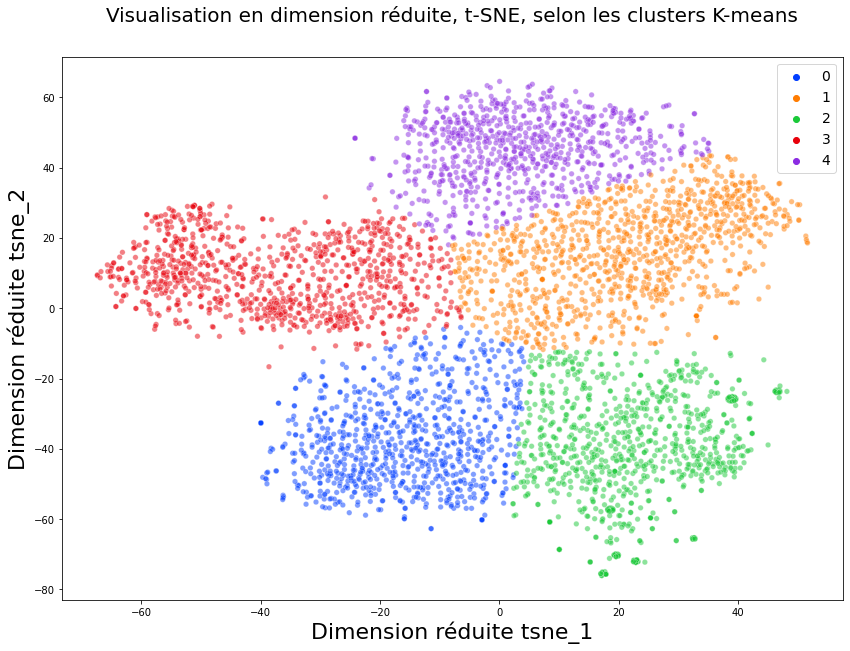

Score ARI - Transfer Learning = 0.682


<IPython.core.display.Javascript object>

In [432]:
(
    photos_features_transfer_learning,
    df_photo_features_tsne_clusters,
) = pipeline_photos_analysis_transfer_learning(
    list_photos_sample, path_photos, df_description_photos_sample, vgg16_model
)

> ###  <font color=#0088B4>Synthèse</font>
- Les résultats sont très bons et bien meilleurs qu'avec la modélisation précédente.
- Le score ARI est de 0.68.
- Les catégories des photos sont clairement séparables et identifiables :
    - Le cluster 0 correspond à la catégorie : **menu**.
    - Le cluster 1 correspond à la catégorie : **inside**.
    - Le cluster 2 correspond à la catégorie : **drink**.
    - Le cluster 3 correspond à la catégorie : **outside**.
    - Le cluster 4 correspond à la catégorie : **food**.

> ## <font style='color:#036BB2'>Clustering sur les features d'origines des photos (sans réduction de dimension)</font> 

In [433]:
photos_features_transfer_learning.shape

(4500, 4096)

<IPython.core.display.Javascript object>

In [434]:
# clusters_photos_transfer_learning = MiniBatchKMeans(5, random_state=42)
clusters_photos_transfer_learning = KMeans(5, random_state=42)

<IPython.core.display.Javascript object>

In [435]:
clusters_photos_transfer_learning.fit(photos_features_transfer_learning)

KMeans(n_clusters=5, random_state=42)

<IPython.core.display.Javascript object>

In [436]:
df_description_photos_sample[
    "clusters_features_photo_transfer_learning"
] = clusters_photos_transfer_learning.labels_

<IPython.core.display.Javascript object>

In [437]:
labels = df_description_photos_sample["label"]
clusters_features = df_description_photos_sample[
    "clusters_features_photo_transfer_learning"
]
score_ari = compute_ari_score(labels, clusters_features)
print(
    "Score ARI - Transfer Learning - clusters sur les features des photos = %.3f"
    % (score_ari)
)

Score ARI - Transfer Learning - clusters sur les features des photos = 0.615


<IPython.core.display.Javascript object>

#### Le score ARI est bon mais légèrement inférieur à celui du clustering sur les composantes du modèle T-SNE (features en dimensions réduites)

# <span style='color:blue' id="section_5" >5. Conclusion</span>
- Les résultats avec l'algorithme SIFT ne sont pas très satisfaisants.
    - Une seule catégorie de photos est à peu près identifiable et séparée.
    - Le score ARI est très faible.
- Les résultats sont bien meilleurs avec la modélisation CNN + Transfer Learning
    - Toutes les catégories de photos sont clairement identifiables et séparables.
    - Le score ARI est élevé.
> **Cette étude montre que l'objectif fixé : déterminer les catégories des photos à partir de l'analyse des photos, est atteignable en utilisant un réseau de neurones de type CNN et en faisant du Transfer Learning**